# Compare 7T predictions

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
ml_per_pix = (512/256)*(512/256)*0.625*0.625*6/1000
ml_per_pix

[1] 0.009375

In [3]:
theme_set(theme_minimal())
options(repr.plot.width = 14)

In [4]:
prepare_confusion_table <- function(data){
   return(data %>% mutate(
            Id=str_replace(image,"_slice.*",""),
            slice=str_replace(image,".*_slice(\\d+)_frame.*","\\1") %>% as.numeric,
            frame=str_replace(image,".*_frame(\\d+)","\\1") %>% as.numeric,
            #total=256*256,
            bg_all=bg_bg+bg_lv+bg_my,
            all_bg=bg_bg+lv_bg+my_bg,
            lv_all=lv_bg+lv_lv+lv_my,
            all_lv=bg_lv+lv_lv+my_lv,
            dice_lv=if_else(lv_all+all_lv==0, 1, 2*lv_lv/(lv_all+all_lv)),
            my_all=my_bg+my_lv+my_my,
            all_my=bg_my+lv_my+my_my,
            dice_my=if_else(my_all+all_my==0, 1, 2*my_my/(my_all+all_my))
        ) %>%
        select(-image)
    ) 
}

In [5]:
conf_matrix <- function(data, mask_bg_bg=FALSE, normalize_row=TRUE){
    if(normalize_row){
        data <- data %>% mutate(
            bg_bg = bg_bg/bg_all,
            bg_lv = bg_lv/bg_all,
            bg_my = bg_my/bg_all,
            lv_bg = lv_bg/lv_all,
            lv_lv = lv_lv/lv_all,
            lv_my = lv_my/lv_all,
            my_bg = my_bg/my_all,
            my_lv = my_lv/my_all,
            my_my = my_my/my_all
        )
    }
    return(data %>% summarize(
            bg_bg=if_else(mask_bg_bg,as.numeric(NA),mean(bg_bg,na.omit=T)),
            bg_lv=mean(bg_lv,na.rm=T),
            bg_my=mean(bg_my,na.rm=T),
            lv_bg=mean(lv_bg,na.rm=T),
            lv_lv=mean(lv_lv,na.rm=T),
            lv_my=mean(lv_my,na.rm=T),
            my_bg=mean(my_bg,na.rm=T),
            my_lv=mean(my_lv,na.rm=T),
            my_my=mean(my_my,na.rm=T)
        ) %>%
            gather("combi","count",contains("_")) %>%
            separate(combi,into=c("a","b"),sep="_")
    )
}

## Interobserver

In [6]:
interobserver <- read_tsv("../../analysis/7T/confusion_tables/confusion_WS_TR.tsv") %>% prepare_confusion_table

Parsed with column specification:
cols(
  image = col_character(),
  set = col_character(),
  methodA = col_character(),
  methodB = col_character(),
  bg_bg = col_double(),
  bg_lv = col_double(),
  bg_my = col_double(),
  lv_bg = col_double(),
  lv_lv = col_double(),
  lv_my = col_double(),
  my_bg = col_double(),
  my_lv = col_double(),
  my_my = col_double()
)


Dice scores for lv and my for all images

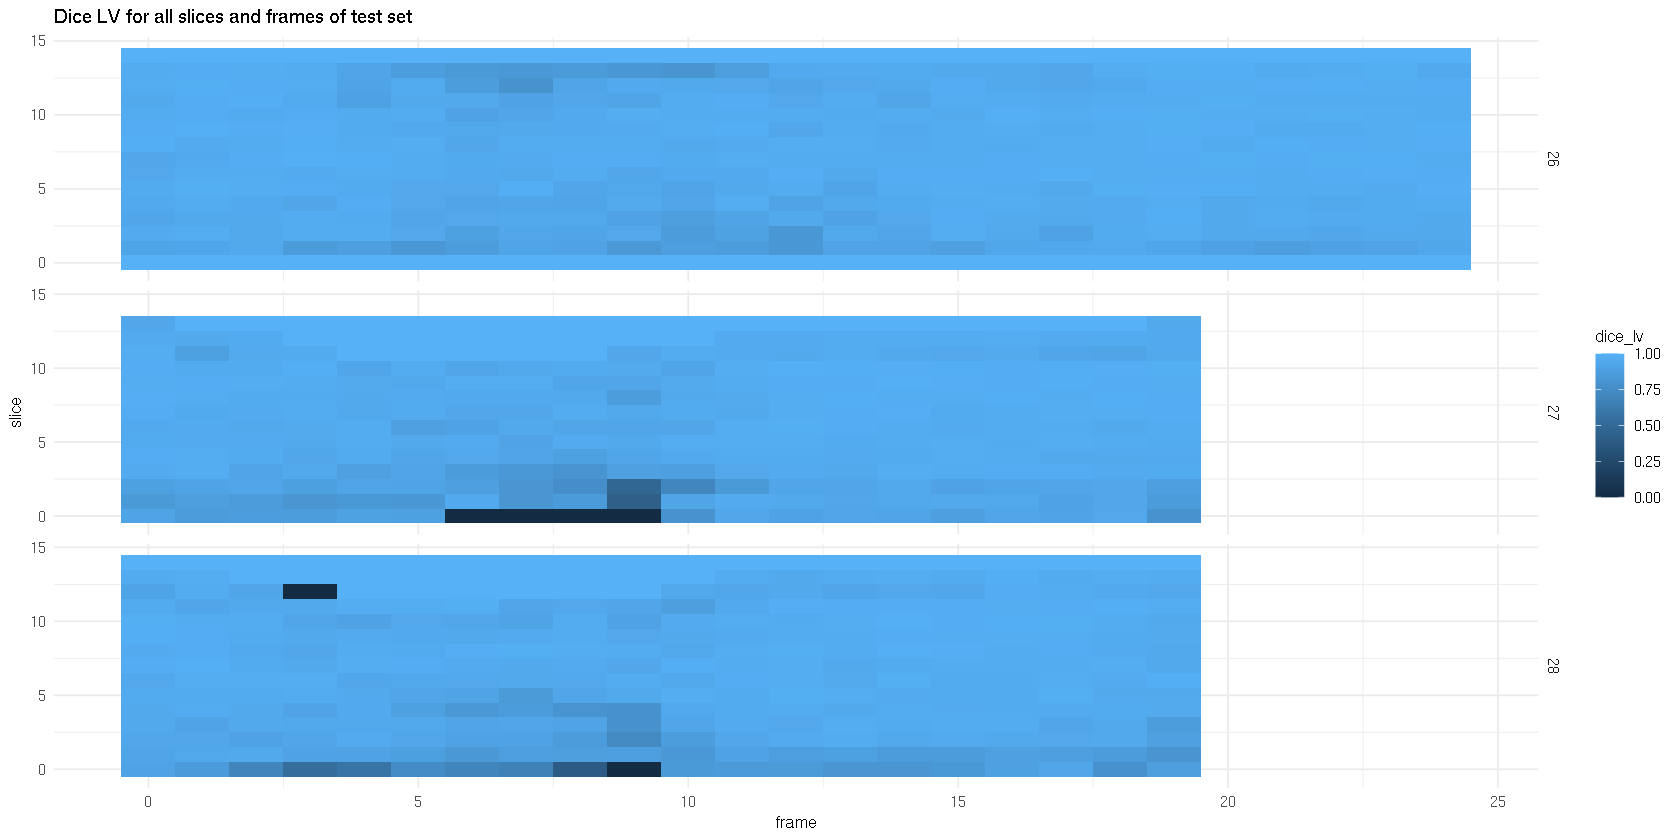

In [7]:
interobserver %>%
    ggplot(aes(x=frame,y=slice,fill=dice_lv)) +
        geom_tile() +
        facet_grid(Id ~ .) +
        ggtitle('Dice LV for all slices and frames of test set')

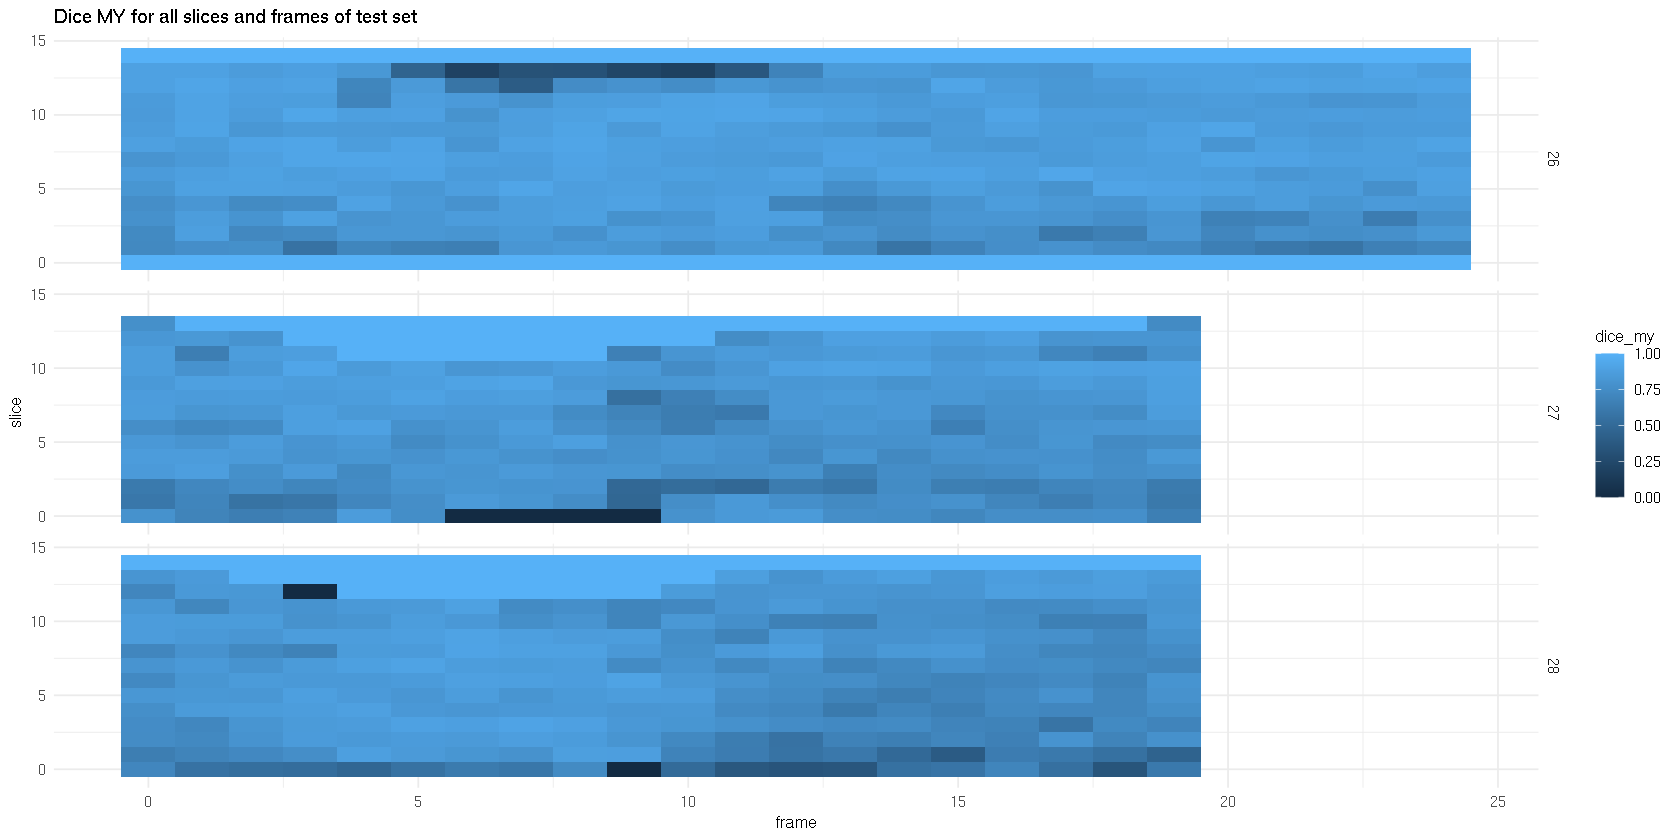

In [8]:
interobserver %>%
    ggplot(aes(x=frame,y=slice,fill=dice_my)) +
        geom_tile() +
        facet_grid(Id ~ .) +
        ggtitle('Dice MY for all slices and frames of test set')

## base network (no transfer learning)

In [9]:
base <- read_tsv("../../analysis/7T/confusion_tables/confusion_WS_base.tsv") %>% prepare_confusion_table

Parsed with column specification:
cols(
  image = col_character(),
  set = col_character(),
  methodA = col_character(),
  methodB = col_character(),
  bg_bg = col_double(),
  bg_lv = col_double(),
  bg_my = col_double(),
  lv_bg = col_double(),
  lv_lv = col_double(),
  lv_my = col_double(),
  my_bg = col_double(),
  my_lv = col_double(),
  my_my = col_double()
)


### dice by image

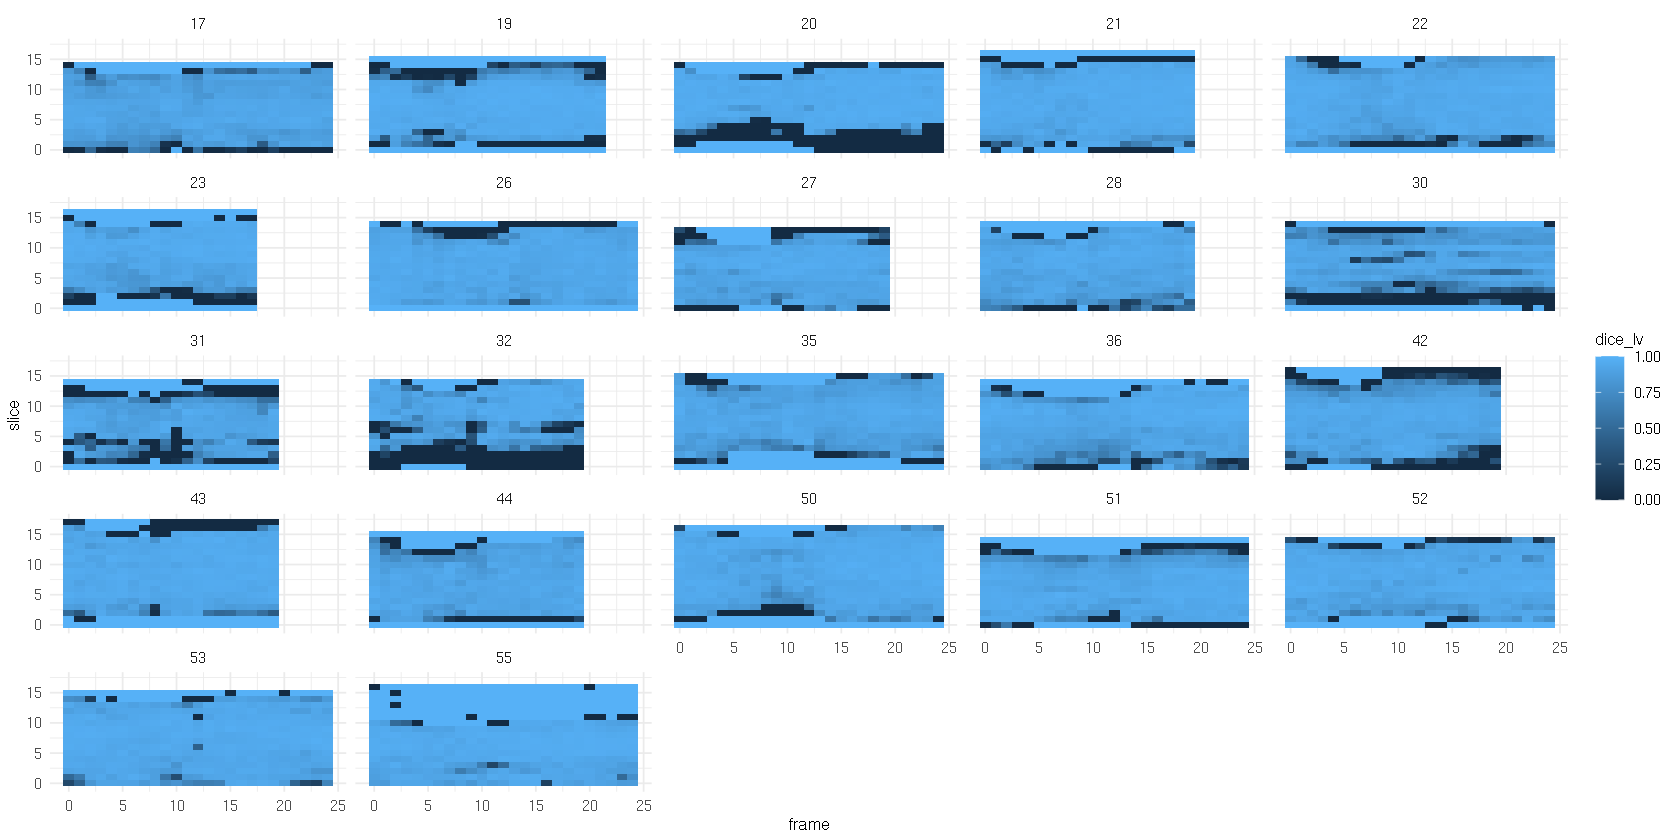

In [10]:
base %>% ggplot(aes(x=frame,y=slice,fill=dice_lv)) + geom_tile() + facet_wrap(Id ~ .)

### confusion matrix

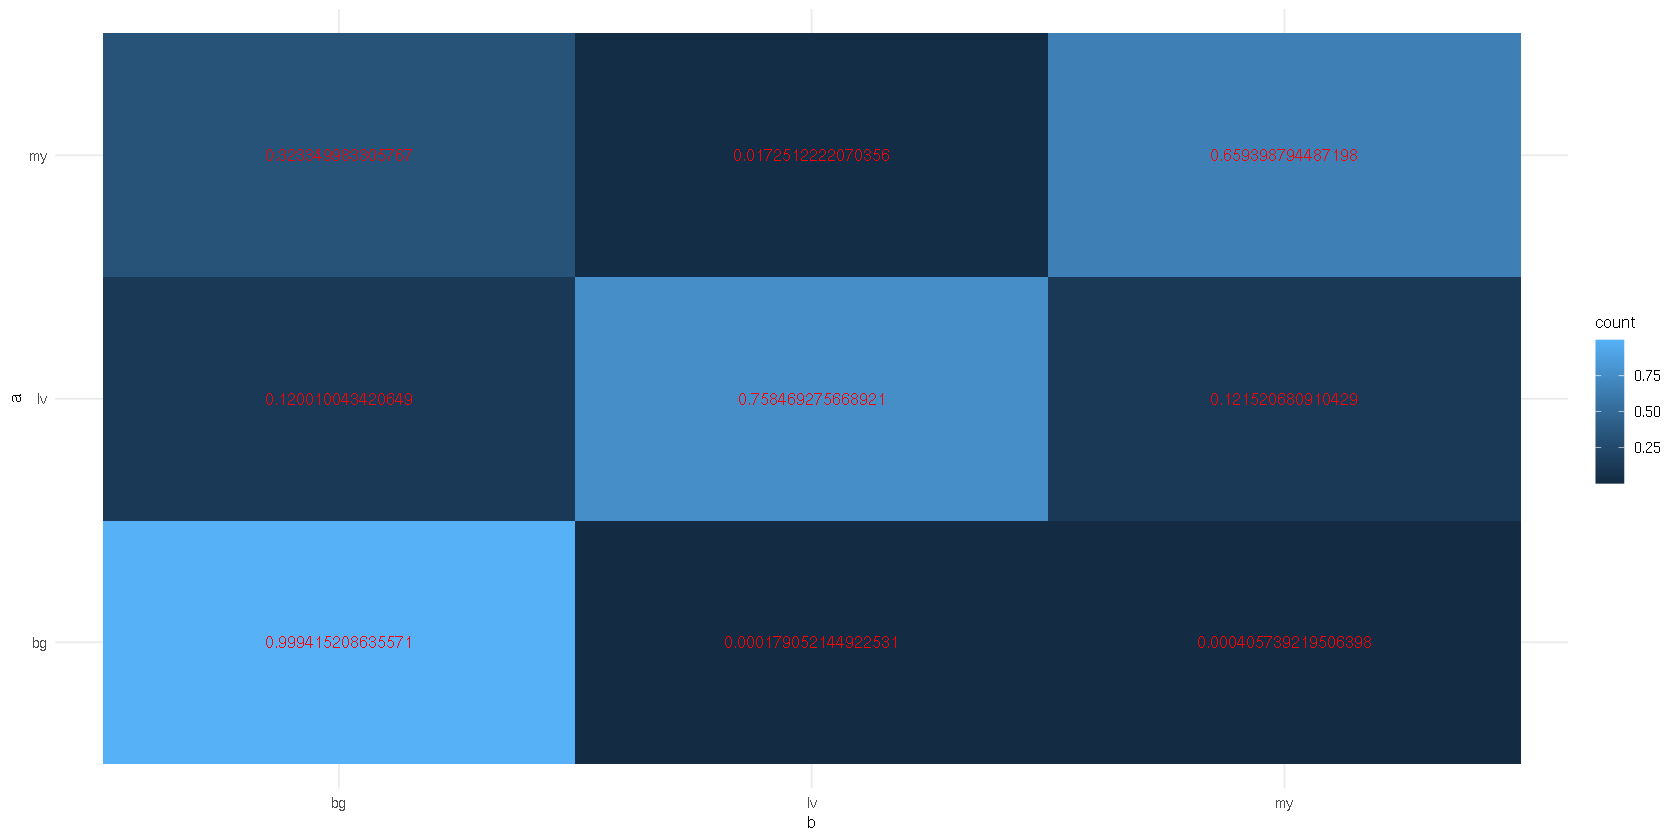

In [11]:
base %>% 
    conf_matrix %>%
    ggplot(aes(b,a,fill=count)) +
    geom_tile() +
    geom_text(aes(label=count),color="red")

by patient

`summarise()` ungrouping output (override with `.groups` argument)


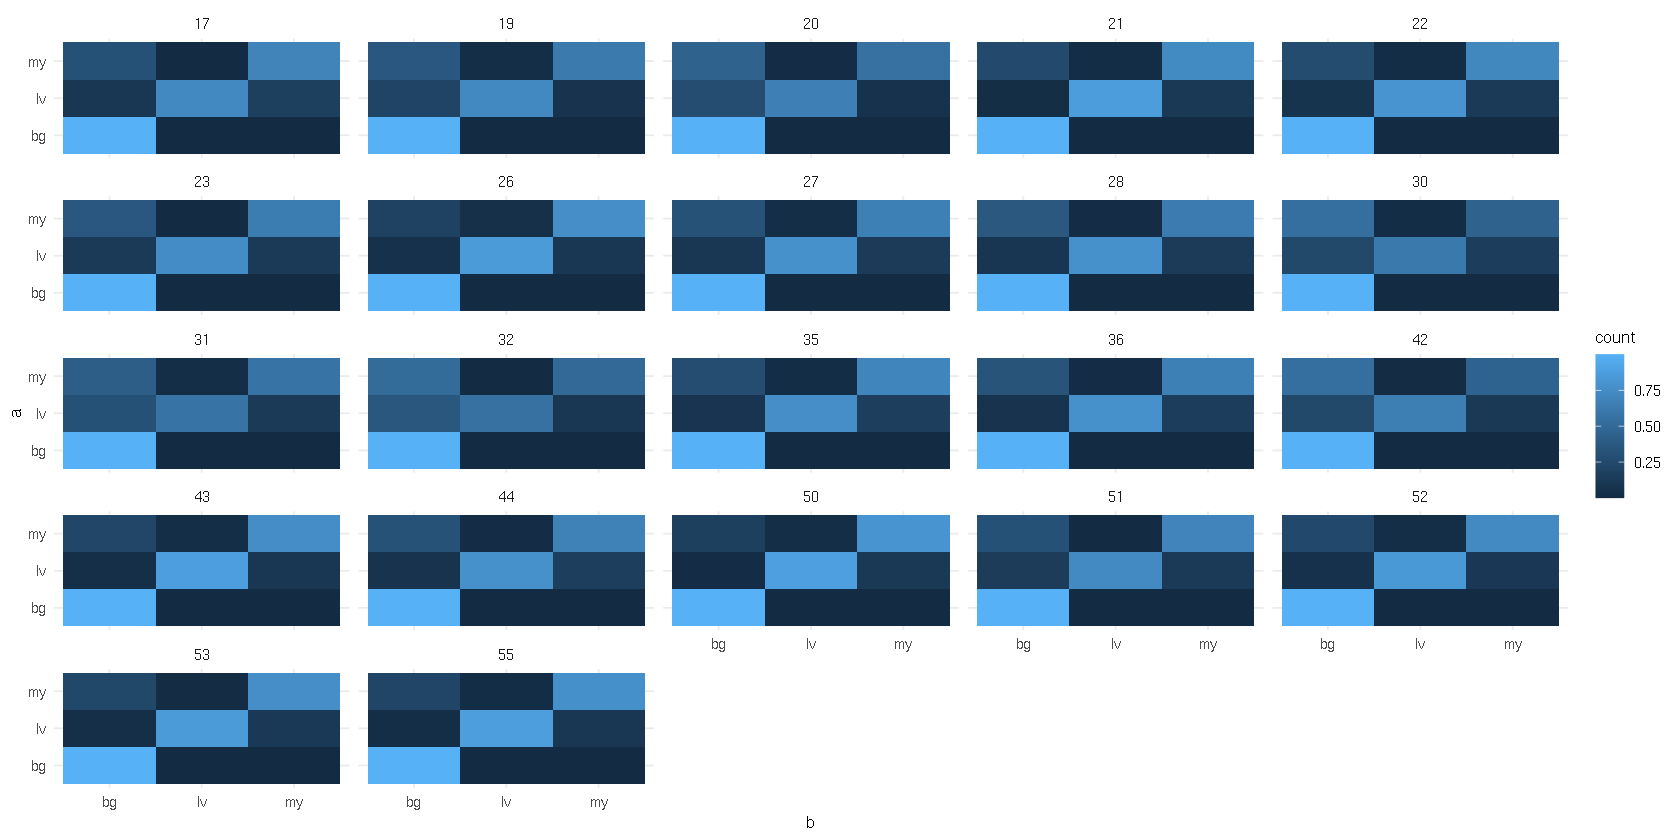

In [12]:
base %>%
    group_by(Id) %>%
    conf_matrix %>%
    ggplot(aes(b,a,fill=count)) +
    geom_tile() +
    facet_wrap(~Id)

### dice by slice/frame

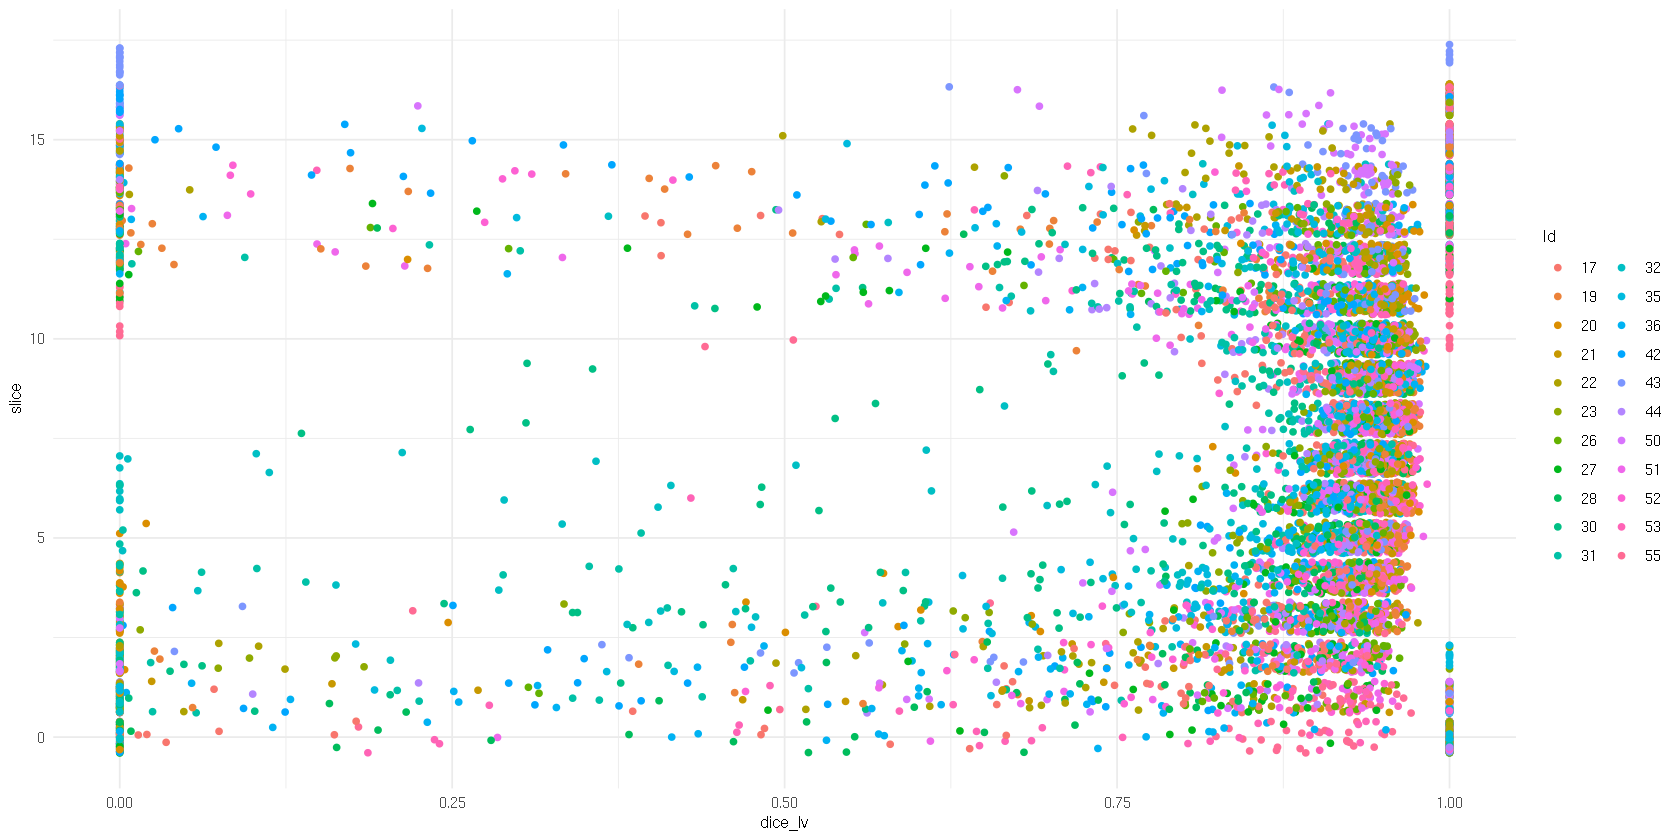

In [13]:
base %>% ggplot(aes(dice_lv,slice)) + geom_jitter(aes(color=Id))

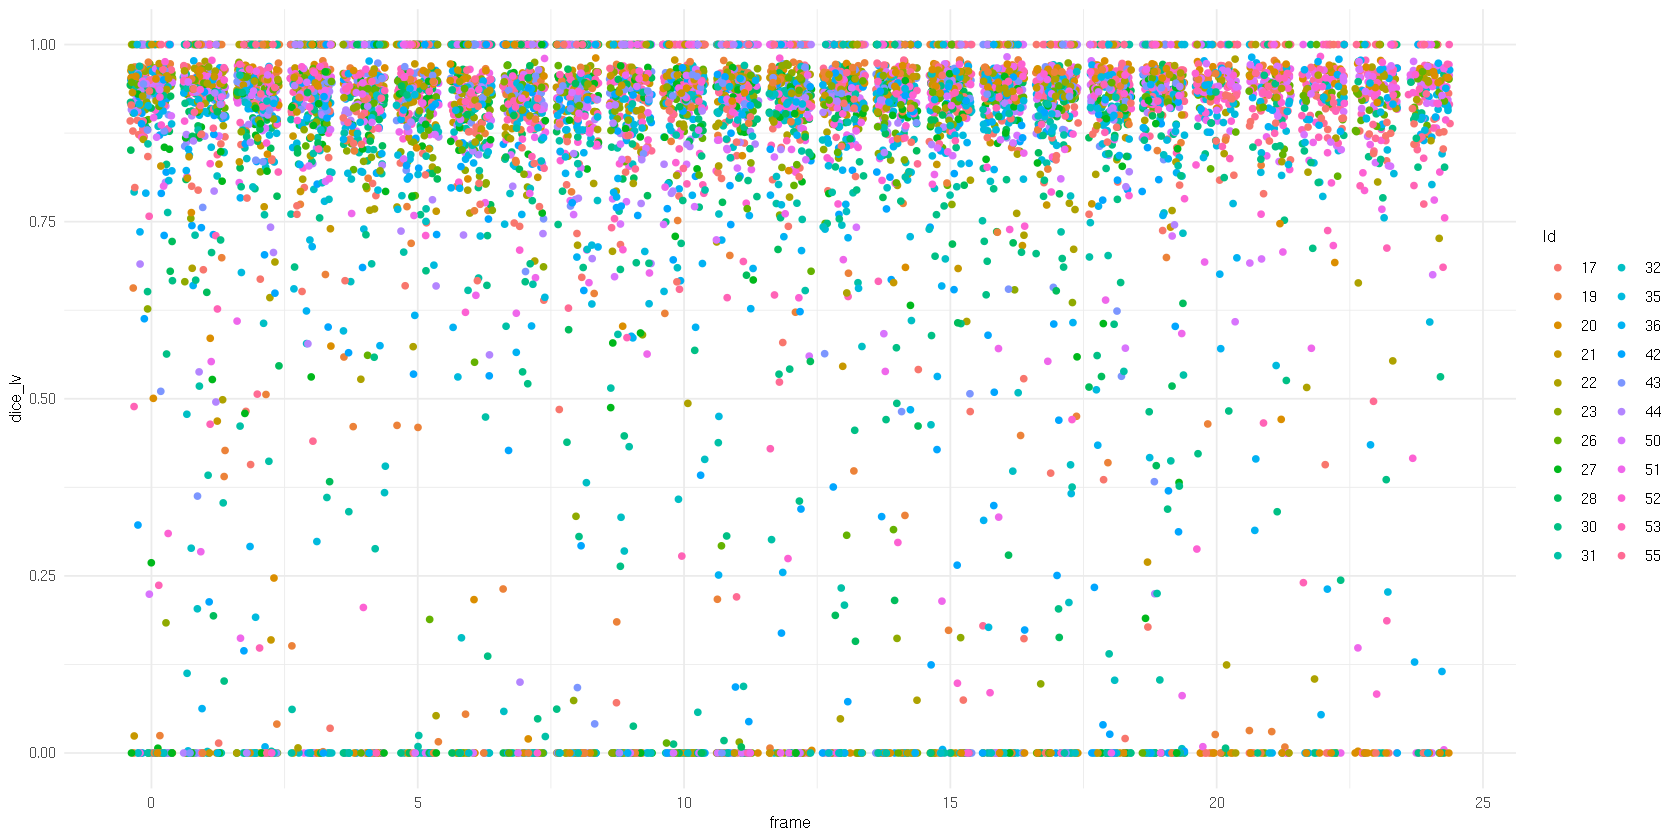

In [14]:
base %>% ggplot(aes(frame,dice_lv)) + geom_jitter(aes(color=Id))

## double TL

In [15]:
doubleTL <- read_tsv("../../analysis/7T/confusion_tables/confusion_WS_doubleTransferLearn.tsv") %>% prepare_confusion_table

Parsed with column specification:
cols(
  image = col_character(),
  set = col_character(),
  methodA = col_character(),
  methodB = col_character(),
  bg_bg = col_double(),
  bg_lv = col_double(),
  bg_my = col_double(),
  lv_bg = col_double(),
  lv_lv = col_double(),
  lv_my = col_double(),
  my_bg = col_double(),
  my_lv = col_double(),
  my_my = col_double()
)


### dice by image

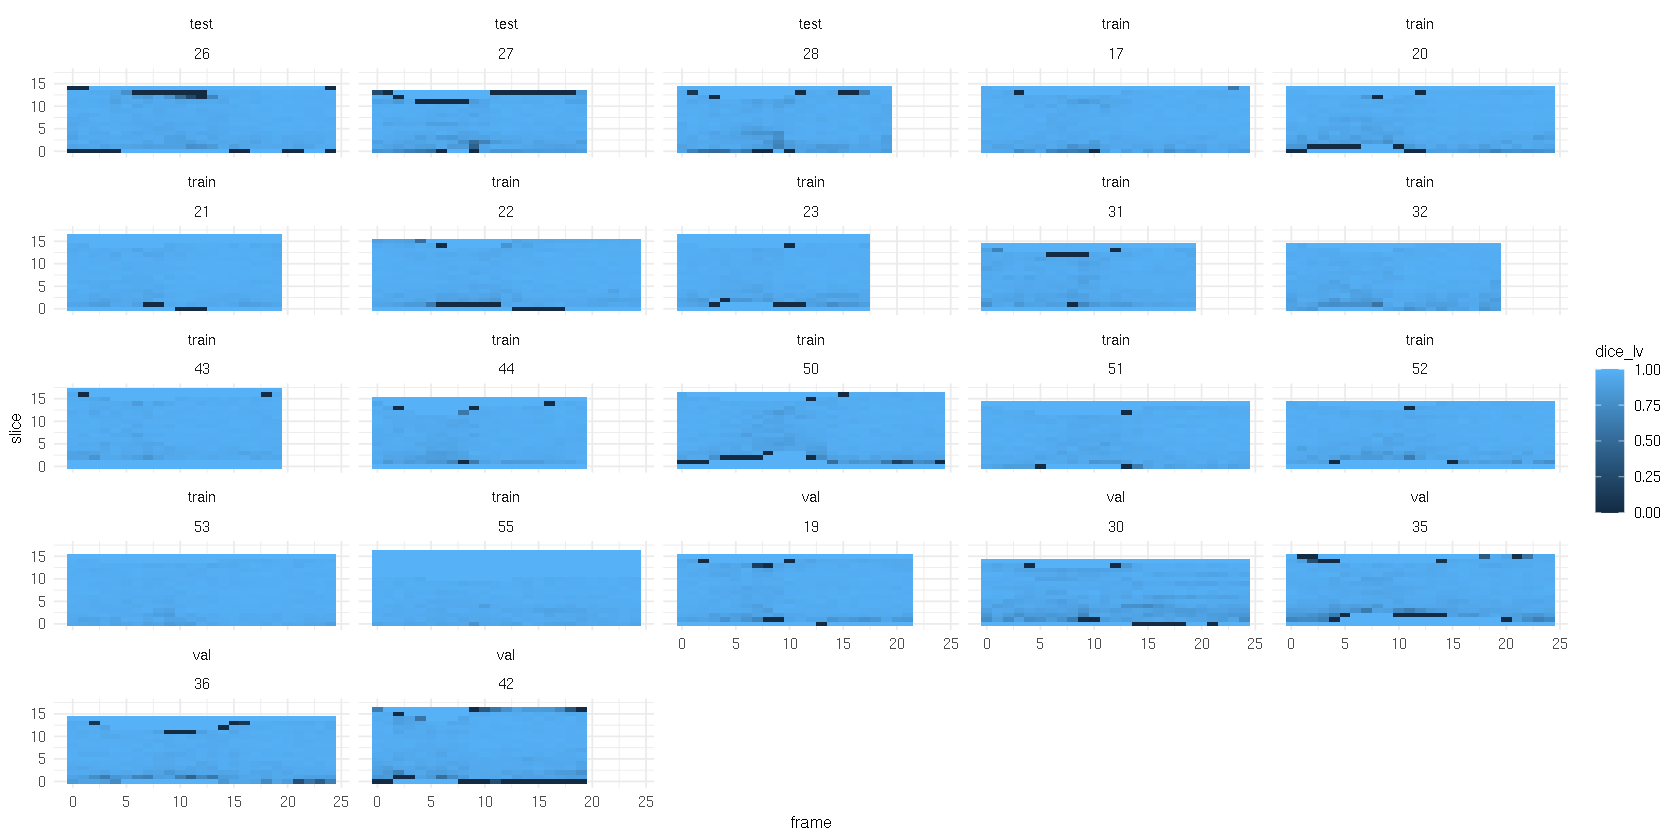

In [16]:
doubleTL %>% ggplot(aes(x=frame,y=slice,fill=dice_lv)) + geom_tile() + facet_wrap(set ~ Id)

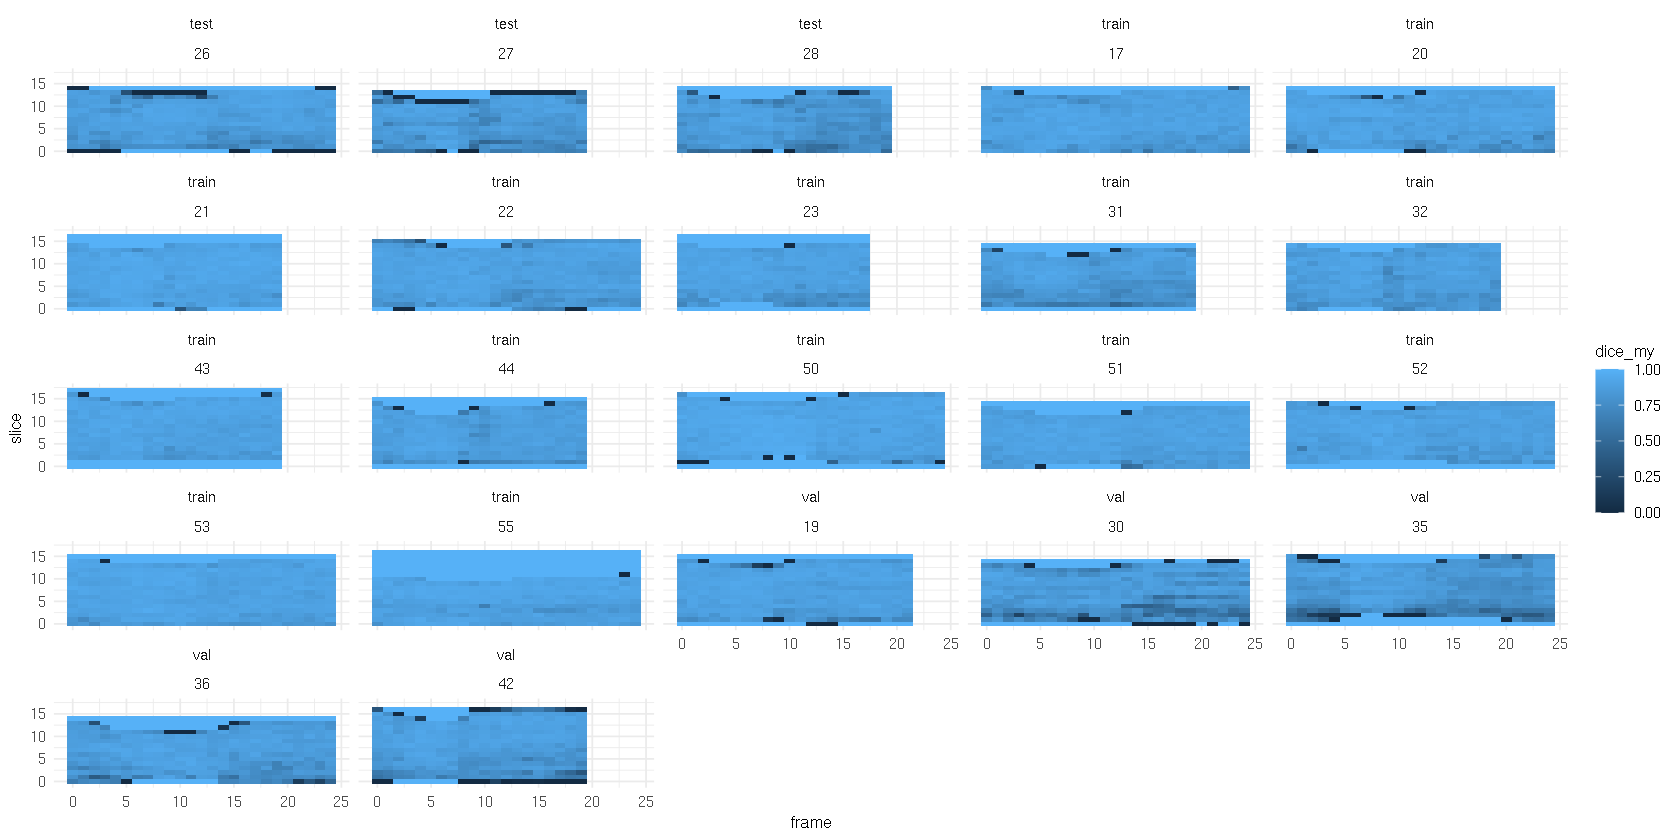

In [17]:
doubleTL %>% ggplot(aes(x=frame,y=slice,fill=dice_my)) + geom_tile() + facet_wrap(set ~ Id)

### confusion matrix

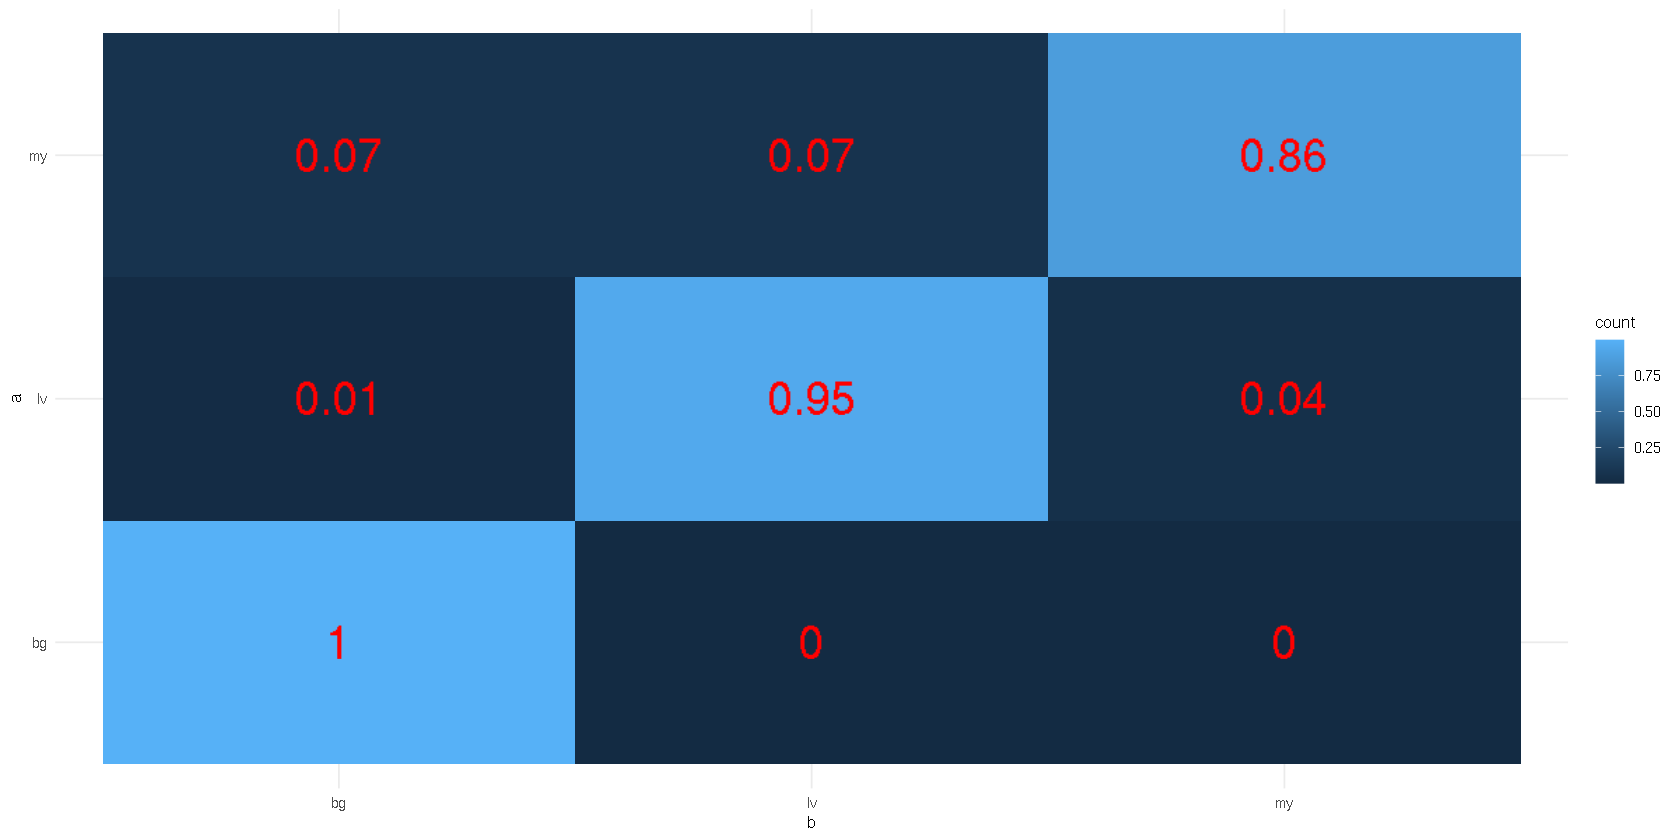

In [18]:
doubleTL %>%
    conf_matrix %>%
    ggplot(aes(b,a,fill=count)) +
    geom_tile() +
    geom_text(aes(label=round(count,digits=2)),color="red",size=10)

### dice by slice/frame

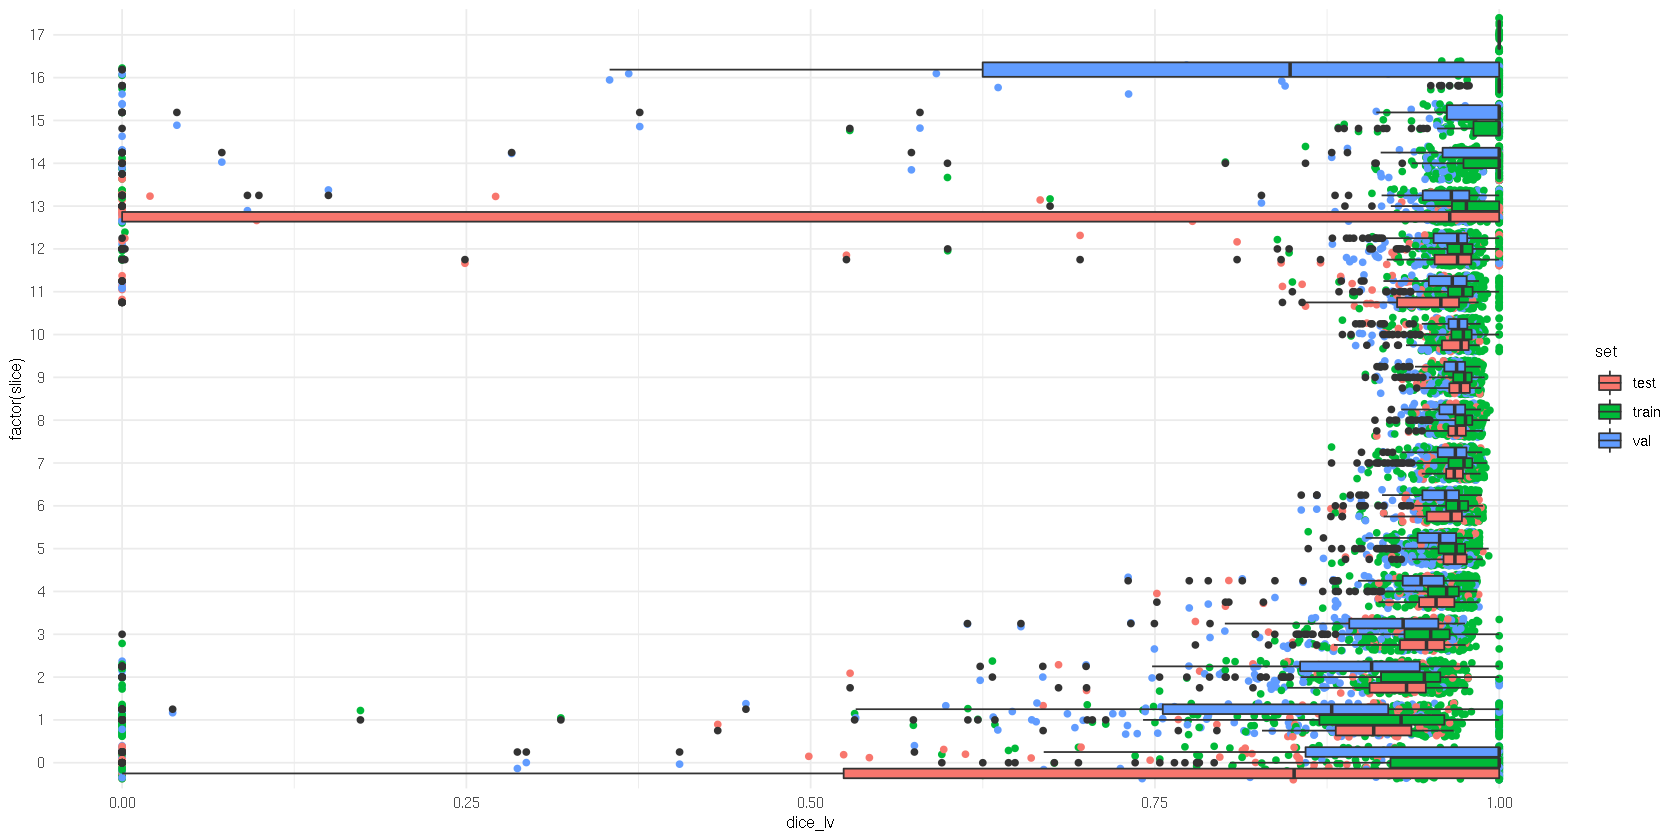

In [19]:
doubleTL %>% ggplot(aes(factor(slice),dice_lv)) + geom_jitter(aes(color=set)) + geom_boxplot(aes(fill=set)) + coord_flip()

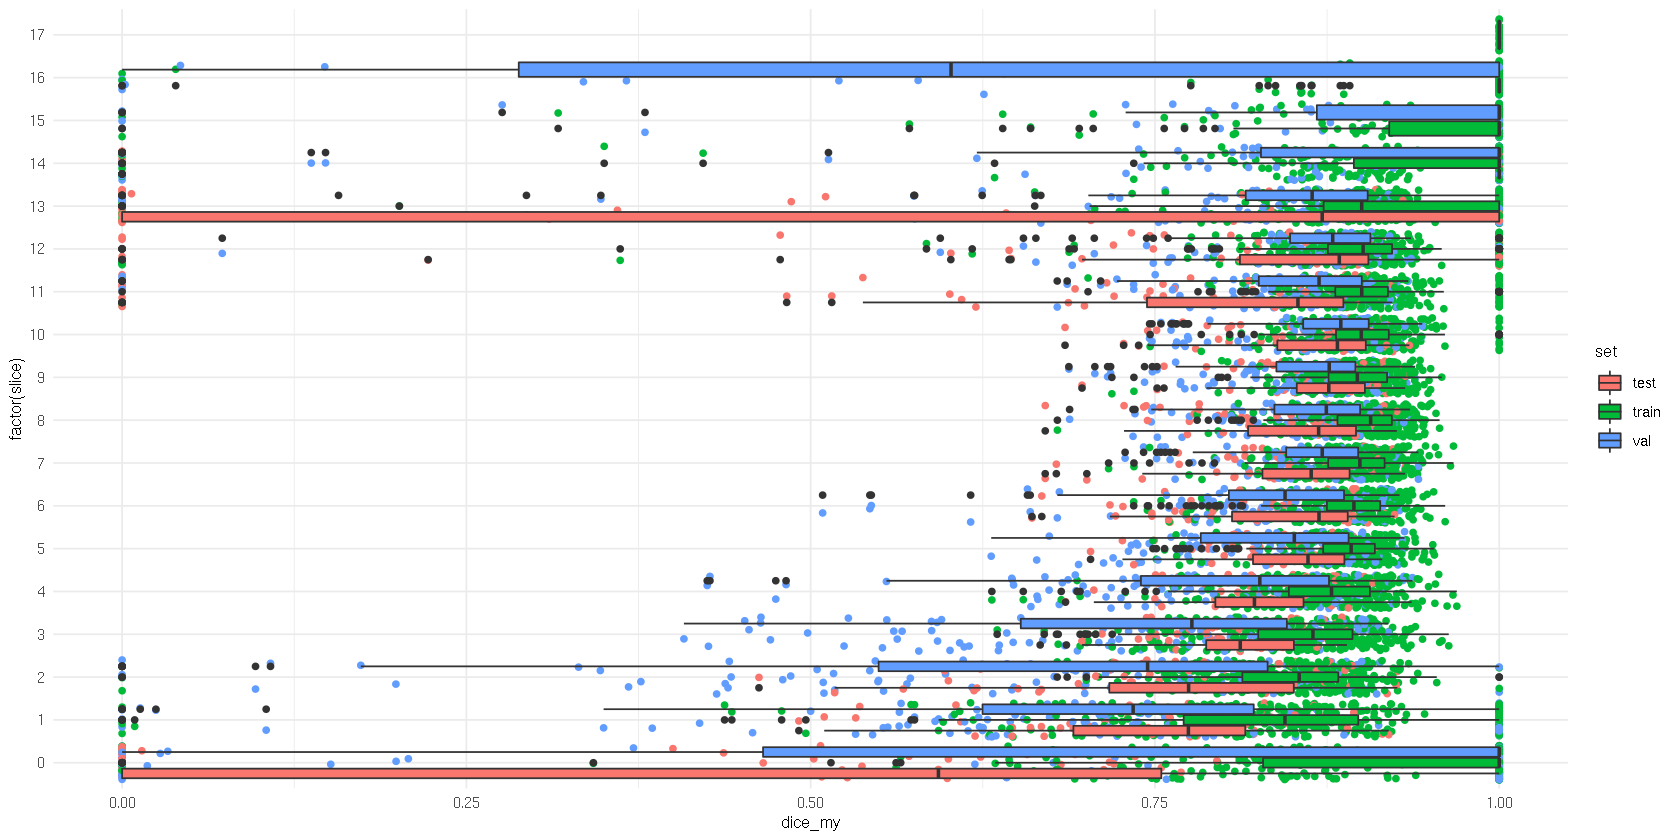

In [20]:
doubleTL %>% ggplot(aes(factor(slice),dice_my)) + geom_jitter(aes(color=set)) + geom_boxplot(aes(fill=set)) + coord_flip()

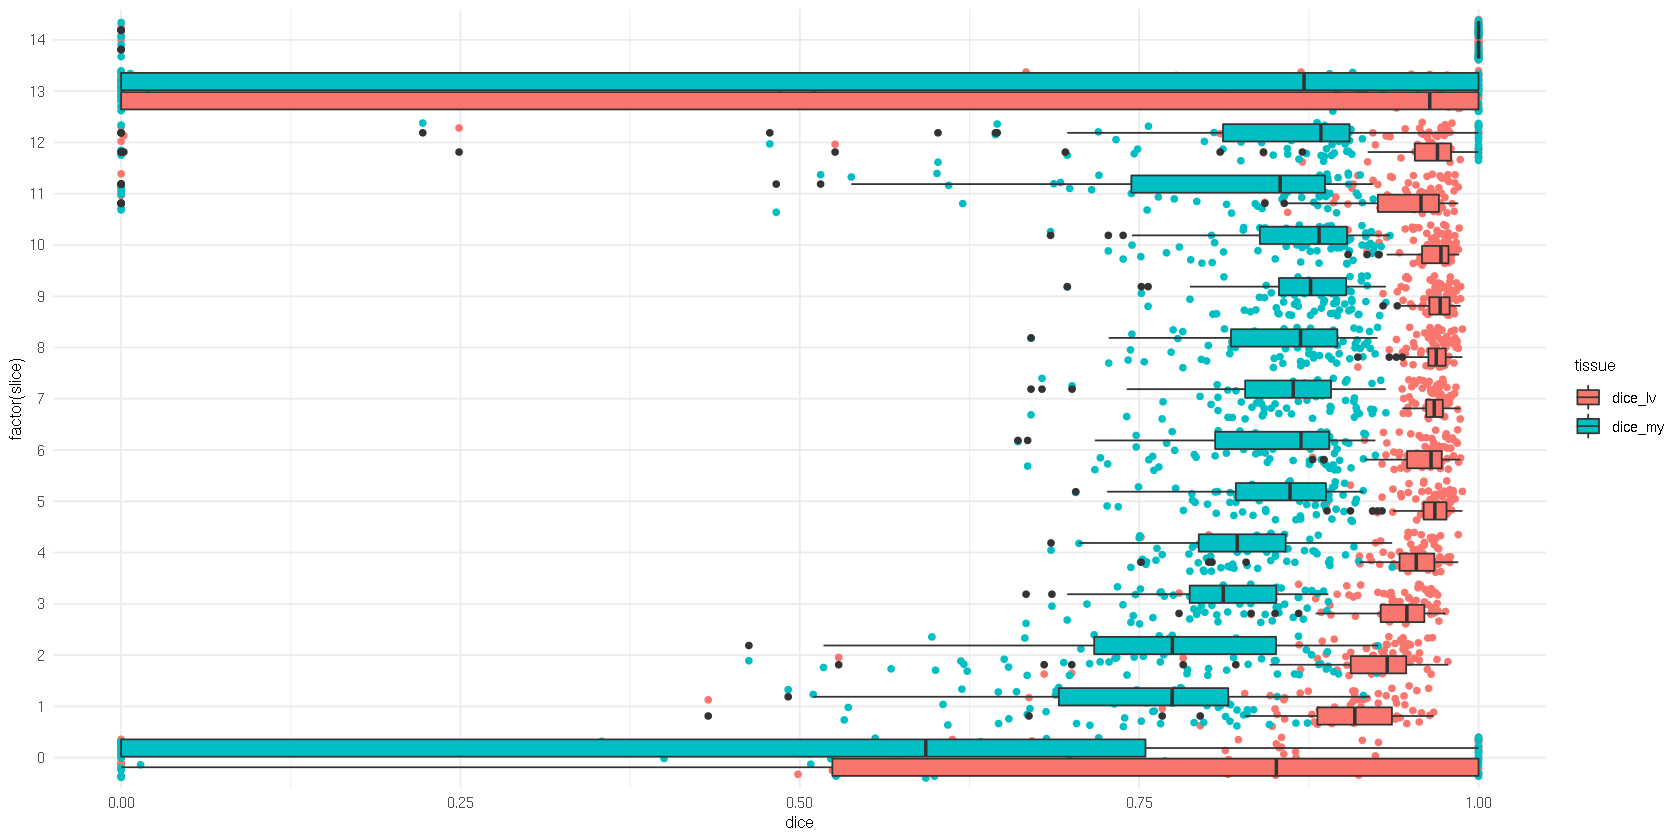

In [21]:
doubleTL %>% filter(set=="test") %>% gather("tissue","dice",dice_lv,dice_my) %>% ggplot(aes(factor(slice),dice)) + geom_jitter(aes(color=tissue)) + geom_boxplot(aes(fill=tissue)) + coord_flip()

## dice tables

In [22]:
plain <- read_tsv("../../analysis/7T/confusion_tables/confusion_WS_plainLearn.tsv") %>% prepare_confusion_table
imagenetTL <- read_tsv("../../analysis/7T/confusion_tables/confusion_WS_imagenetTransferLearn.tsv") %>% prepare_confusion_table
ukbbCardiac <- read_tsv("../../analysis/7T/confusion_tables/confusion_WS_ukbbCardiac.tsv") %>% prepare_confusion_table
secondObserver_doubleTL <- read_tsv("../../analysis/7T/confusion_tables/confusion_TR_doubleTransferLearn.tsv") %>% prepare_confusion_table
doubleTL_esed <- read_tsv("../../analysis/7T/confusion_tables/confusion_WS_doubleTL-esed.tsv") %>% prepare_confusion_table

Parsed with column specification:
cols(
  image = col_character(),
  set = col_character(),
  methodA = col_character(),
  methodB = col_character(),
  bg_bg = col_double(),
  bg_lv = col_double(),
  bg_my = col_double(),
  lv_bg = col_double(),
  lv_lv = col_double(),
  lv_my = col_double(),
  my_bg = col_double(),
  my_lv = col_double(),
  my_my = col_double()
)
Parsed with column specification:
cols(
  image = col_character(),
  set = col_character(),
  methodA = col_character(),
  methodB = col_character(),
  bg_bg = col_double(),
  bg_lv = col_double(),
  bg_my = col_double(),
  lv_bg = col_double(),
  lv_lv = col_double(),
  lv_my = col_double(),
  my_bg = col_double(),
  my_lv = col_double(),
  my_my = col_double()
)
Parsed with column specification:
cols(
  image = col_character(),
  set = col_character(),
  methodA = col_character(),
  methodB = col_character(),
  bg_bg = col_double(),
  bg_lv = col_double(),
  bg_my = col_double(),
  lv_bg = col_double(),
  lv_lv = col_double

### all vs WS

In [23]:
bind_rows(
    interobserver,
    plain,
    imagenetTL,
    base,
    doubleTL,
    ukbbCardiac,
    doubleTL_esed
) %>%
    mutate(methodB=str_replace(methodB,"scaled_masks_","")) %>%
    group_by(set,methodB) %>%
    summarize(dice_lv=mean(dice_lv),dice_my=mean(dice_my))

`summarise()` regrouping output by 'set' (override with `.groups` argument)


set,methodB,dice_lv,dice_my
test,baseModel,0.8352351,0.6695502
test,doubleTransferLearn,0.8999944,0.7910449
test,doubleTransferLearn_esed,0.9080429,0.8047760
test,imagenetTransferLearn,0.9075785,0.7905872
test,plainLearn,0.8795108,0.7556199
test,TR,0.9393260,0.8127338
test,ukbb_preds_3class,0.6677312,0.5213427
train,baseModel,0.8211144,0.6989141
train,doubleTransferLearn,0.9504440,0.8876810
train,doubleTransferLearn_esed,0.9385355,0.8668593


### doubleTL vs second observer

In [24]:
secondObserver_doubleTL %>%
    group_by(set, methodA, methodB) %>%
    summarize(dice_lv=mean(dice_lv),dice_my=mean(dice_my))

`summarise()` regrouping output by 'set', 'methodA' (override with `.groups` argument)


set,methodA,methodB,dice_lv,dice_my
test,scaled_masks_TR,doubleTransferLearn,0.9069554,0.8119143


### base network overall

In [25]:
base %>%
    summarize(dice_lv=mean(dice_lv),dice_my=mean(dice_my))

dice_lv,dice_my
0.8136261,0.676298


### Significance Tests

First look at distribution of dice scores and test for normality

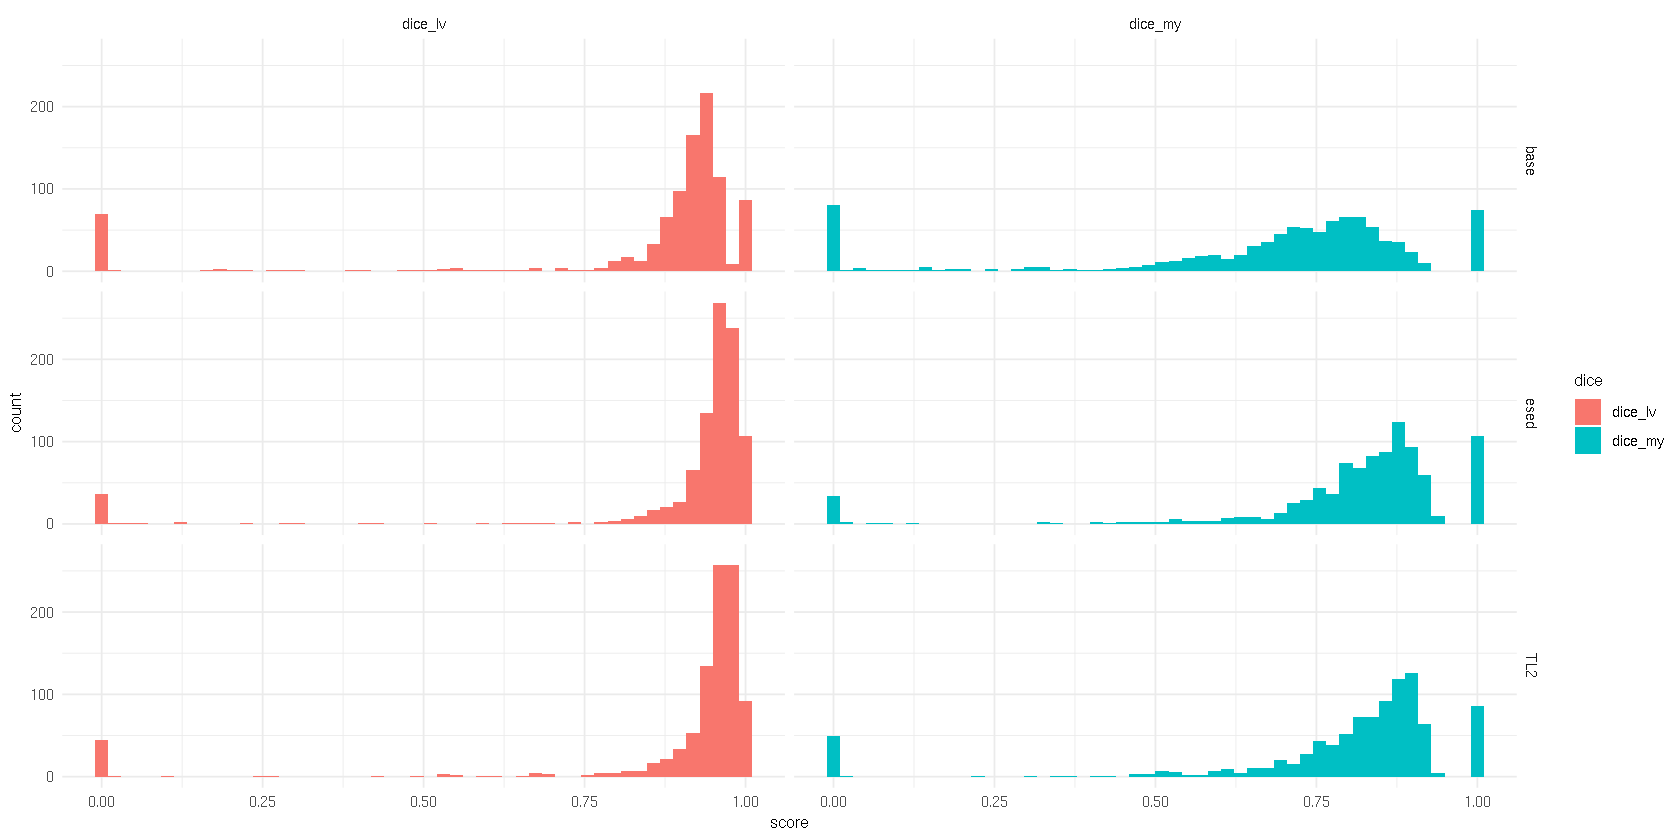

In [26]:
base_dices <- base %>%
    filter(set=="test") %>%
    select(Id, slice, frame, dice_lv, dice_my) %>%
    mutate(model="base")
doubleTL_dices <- doubleTL %>%
    filter(set=="test") %>%
    select(Id, slice, frame, dice_lv, dice_my) %>%
    mutate(model="TL2")
esed_dices <- doubleTL_esed %>%
    filter(set=="test") %>%
    select(Id, slice, frame, dice_lv, dice_my) %>%
    mutate(model="esed")
bind_rows(base_dices, doubleTL_dices, esed_dices) %>%
    gather("dice", "score", dice_lv,dice_my) %>%
    ggplot(aes(score, fill=dice)) +
        geom_histogram(bins=50) +
        facet_grid(model ~ dice)

In [27]:
shapiro.test(base_dices$dice_lv)
shapiro.test(base_dices$dice_my)
shapiro.test(doubleTL_dices$dice_lv)
shapiro.test(doubleTL_dices$dice_my)
shapiro.test(esed_dices$dice_lv)
shapiro.test(esed_dices$dice_my)


	Shapiro-Wilk normality test

data:  base_dices$dice_lv
W = 0.52181, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  base_dices$dice_my
W = 0.80951, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  doubleTL_dices$dice_lv
W = 0.40022, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  doubleTL_dices$dice_my
W = 0.65486, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  esed_dices$dice_lv
W = 0.37759, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  esed_dices$dice_my
W = 0.6661, p-value < 2.2e-16


The general impression of non-normality is confirmed with Shapiro-Wilk test - so use wilcoxon instead of paired t-tests

In [28]:
base_vs_doubleTL <- left_join(base_dices, doubleTL_dices, by=c("Id","slice","frame"))
wilcox.test(base_vs_doubleTL$dice_lv.x, base_vs_doubleTL$dice_lv.y, paired=TRUE)
wilcox.test(base_vs_doubleTL$dice_my.x, base_vs_doubleTL$dice_my.y, paired=TRUE)


	Wilcoxon signed rank test with continuity correction

data:  base_vs_doubleTL$dice_lv.x and base_vs_doubleTL$dice_lv.y
V = 45791, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank test with continuity correction

data:  base_vs_doubleTL$dice_my.x and base_vs_doubleTL$dice_my.y
V = 41036, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [29]:
esed_vs_doubleTL <- left_join(esed_dices, doubleTL_dices, by=c("Id","slice","frame"))
wilcox.test(esed_vs_doubleTL$dice_lv.x, esed_vs_doubleTL$dice_lv.y, paired=TRUE)
wilcox.test(esed_vs_doubleTL$dice_my.x, esed_vs_doubleTL$dice_my.y, paired=TRUE)


	Wilcoxon signed rank test with continuity correction

data:  esed_vs_doubleTL$dice_lv.x and esed_vs_doubleTL$dice_lv.y
V = 147705, p-value = 4.978e-05
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank test with continuity correction

data:  esed_vs_doubleTL$dice_my.x and esed_vs_doubleTL$dice_my.y
V = 151160, p-value = 4.265e-05
alternative hypothesis: true location shift is not equal to 0


Even this difference is statistically significant. A general problem is that the assumption of independence is violated (we have many similar images from neighboring slices/timepoints and only 3 different volunteers). Therefore the significance is inflated and the p-values can not be trusted. It is better to not use these values for communication as interpretability is very limited.

## Figure for paper: LV volume difference by image

In [30]:
esed_frames <- read_tsv("../../analysis/7T/esed_frames.tsv", col_types = "cnn")
esed_frames %>% filter(Id %in% c(26,27,28))

Id,es,ed
26,9,24
27,7,0
28,8,19


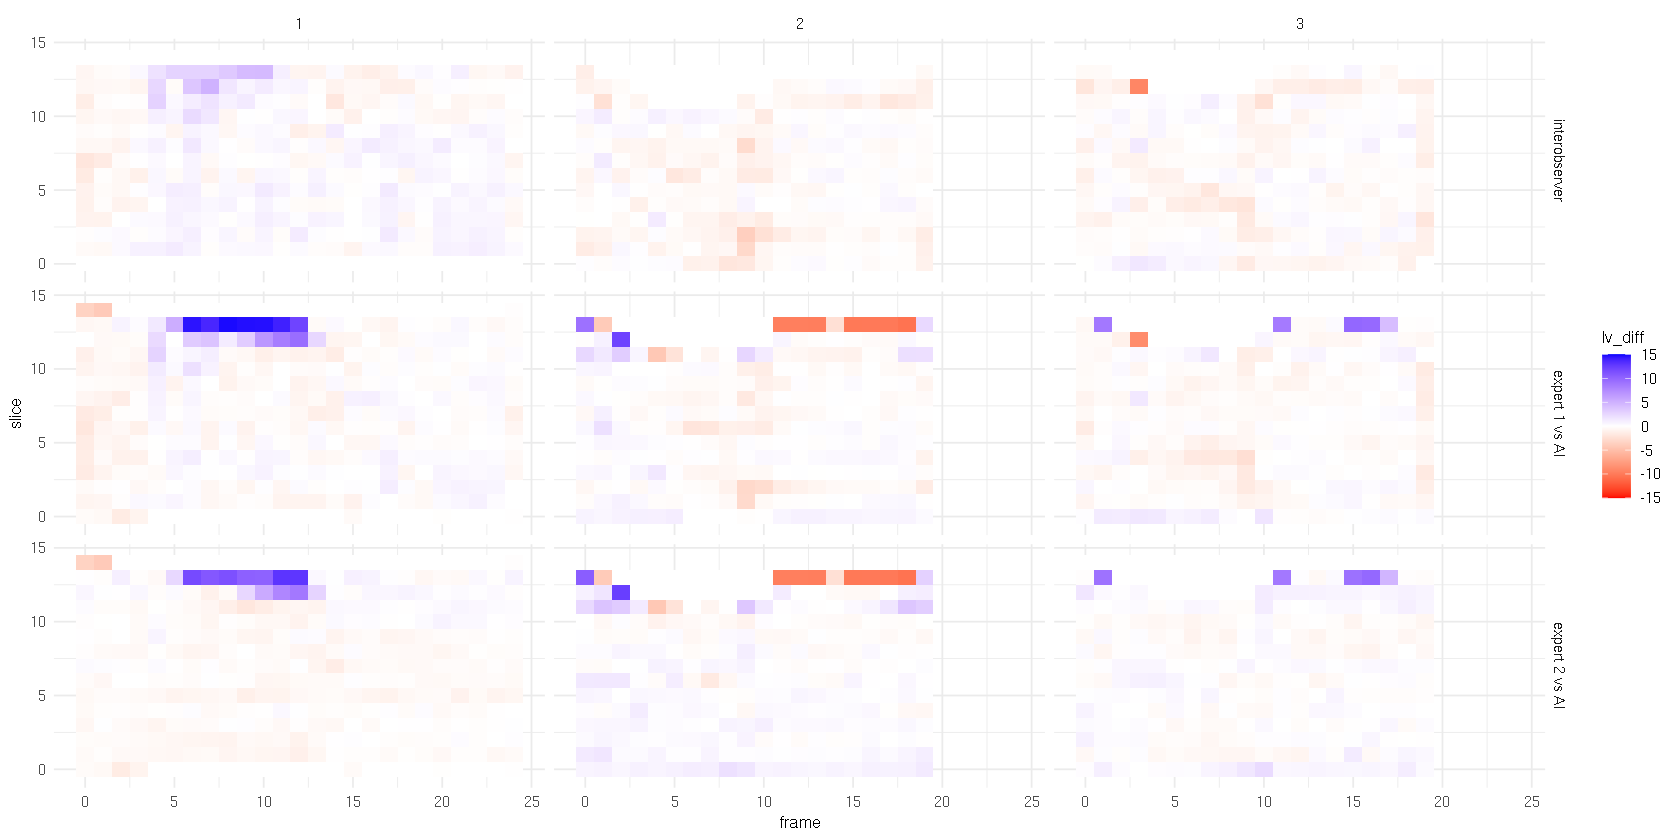

In [31]:
bind_rows(list(interobserver=interobserver,"expert 1 vs AI"=doubleTL,"expert 2 vs AI"=secondObserver_doubleTL), .id = 'source') %>%
    filter(set=="test") %>%
    mutate(
        Id = as.character(as.numeric(Id) - 25),
        lv_diff=(lv_all-all_lv)*ml_per_pix,
        source = fct_relevel(source,"interobserver"),
        max_slice=max(slice)
    ) %>%
    left_join(esed_frames, by="Id") %>%
    ggplot(aes(x=frame,y=slice,fill=lv_diff)) +
        geom_tile() +
        facet_grid(source ~ Id) +
        scale_fill_gradient2(low = "red", mid = "white", high = "blue", midpoint = 0, limits=c(-15,15)) #+
    #    geom_rect(data=. %>% filter(es==frame,slice==0),aes(xmin=es-.5,xmax=es+.5,ymin=-.5,ymax=max_slice+.5),color="purple",alpha=0) +
    #    geom_rect(data=. %>% filter(ed==frame,slice==0),aes(xmin=ed-.5,xmax=ed+.5,ymin=-.5,ymax=max_slice+.5),color="darkgreen",alpha=0)

looking at volume differences for images with low dice score (below .5, indicated with a dot in the next plot) reveals that many low dice scores are in apical slices that contribute little volume information.

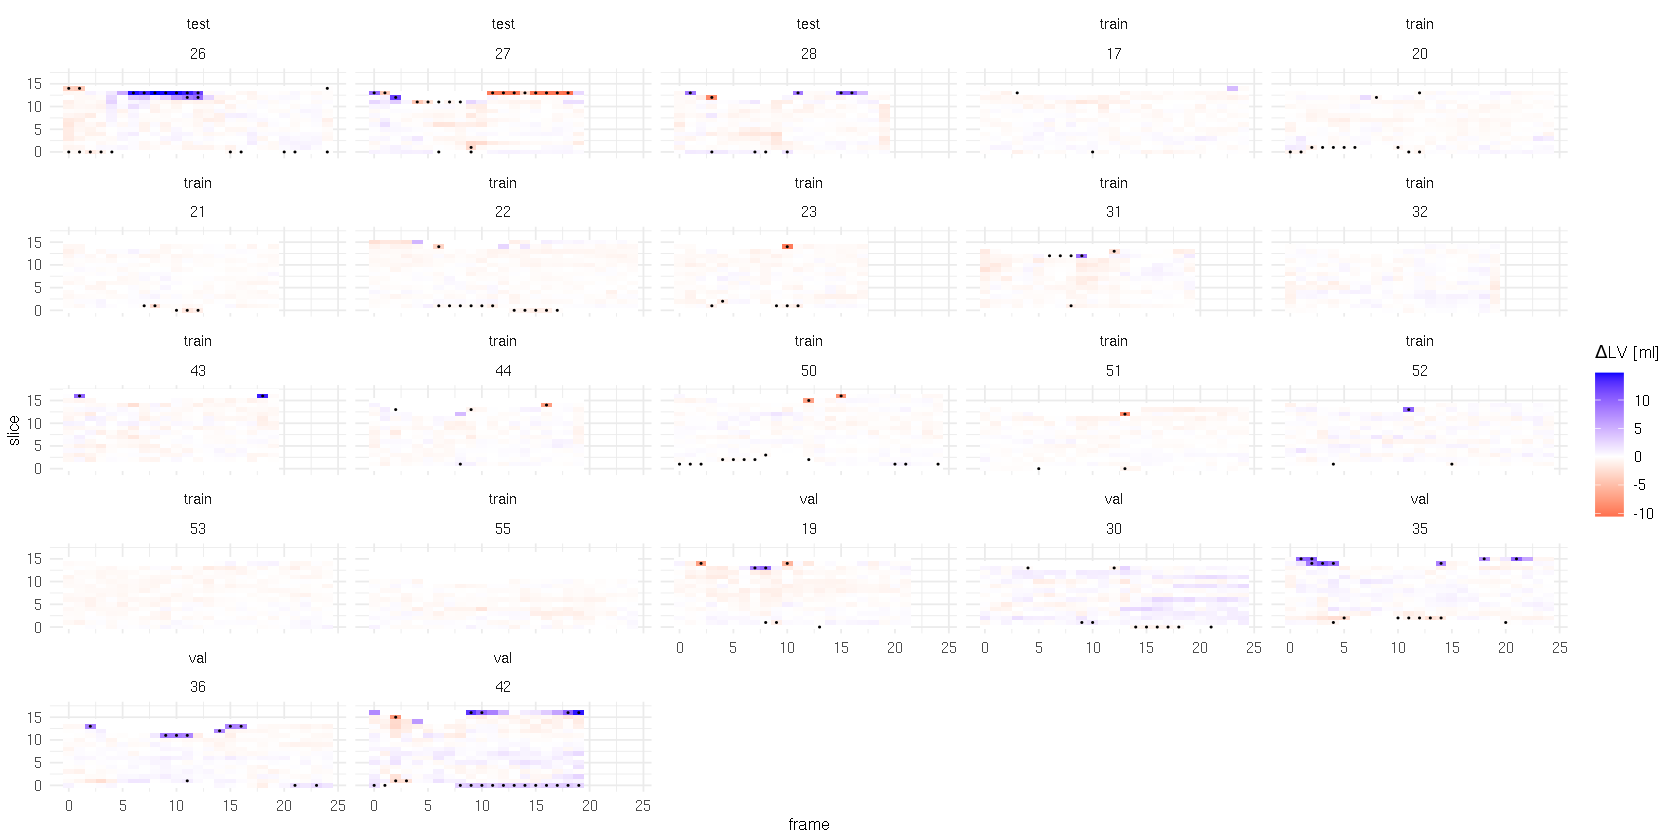

In [32]:
doubleTL %>%
    mutate(lv_diff=(lv_all-all_lv)*ml_per_pix) %>%
    ggplot(aes(x=frame,y=slice,fill=lv_diff)) +
        geom_tile() +
        facet_wrap(set ~ Id) +
        scale_fill_gradient2(low = "red", mid = "white", high = "blue", midpoint = 0) +
        geom_point(data=filter(doubleTL,dice_lv<.5),aes(fill=NULL),size=.2) + labs(fill = expression(paste(Delta,"LV [ml]")))

In [33]:
# get images from the test set with good, intermediate and low dice values
doubleTL %>% filter(all_lv > 1000, set=="test") %>% arrange(-dice_lv) %>% slice(1,230,431) %>% select(Id, slice, frame, lv_all, my_all, dice_lv, dice_my)

Id,slice,frame,lv_all,my_all,dice_lv,dice_my
27,5,12,1180,452,0.9881054,0.9008264
26,10,14,1395,930,0.9694574,0.8825093
27,10,10,1165,762,0.9323127,0.7795945


### interobserver variability values

In [34]:
interobserver_variability <- function(data){
    result <- data %>%
        left_join(esed_frames) %>%
        mutate(special_frame = case_when(
            frame == es ~ "ES",
            frame == ed ~ "ED",
            TRUE ~ "none"
        )) %>%
        filter(special_frame!="none",set=="test") %>%
        select(Id,slice,special_frame,all_lv,lv_all) %>%
        mutate(
            all_lv=all_lv*ml_per_pix,
            lv_all=lv_all*ml_per_pix,
        ) %>%
        group_by(Id,special_frame) %>%
        summarize(sum_lv=sum(lv_all), sum_lv2=sum(all_lv)) %>%
        ungroup() %>%
        tidyr::pivot_wider(names_from=special_frame, values_from=c(sum_lv,sum_lv2)) %>%
        mutate(
            SV1=sum_lv_ED-sum_lv_ES,
            SV2=sum_lv2_ED-sum_lv2_ES,
            EF1=SV1/sum_lv_ED,
            EF2=SV2/sum_lv2_ED,
            EDV=abs(sum_lv2_ED-sum_lv_ED)*100/sum_lv_ED,
            ESV=abs(sum_lv2_ES-sum_lv_ES)*100/sum_lv_ES,
            SV=abs(SV2-SV1)*100/SV1,
            EF=abs(EF2-EF1)*100/EF1
        ) %>% select(EDV:EF) %>% summarize_all(mean) %>% mutate_all(round,1)
    return(result)
}

In [35]:
interobserver_variability(interobserver)

Joining, by = "Id"
`summarise()` regrouping output by 'Id' (override with `.groups` argument)


EDV,ESV,SV,EF
4.8,6.6,9,6


In [36]:
interobserver_variability(doubleTL)

Joining, by = "Id"
`summarise()` regrouping output by 'Id' (override with `.groups` argument)


EDV,ESV,SV,EF
6.4,10.5,17.4,11.2


In [37]:
interobserver_variability(secondObserver_doubleTL)

Joining, by = "Id"
`summarise()` regrouping output by 'Id' (override with `.groups` argument)


EDV,ESV,SV,EF
4.3,4.2,11.3,7.4
